# Study 2: Field experiment

## Libraries

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import scipy
from scipy import stats
import statsmodels.api as sm
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 8]
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from curlyBrace import curlyBrace

In [2]:
# Print library versions
print("numpy version: " + str(np.__version__))
print("pandas version: " + str(pd.__version__))
print("scipy version: " + str(scipy.__version__))
print("statsmodels version: " + str(sm.__version__))
print("matplotlib version: " + str(matplotlib.__version__))
print("seaborn version: " + str(sns.__version__))

numpy version: 1.24.3
pandas version: 1.5.3
scipy version: 1.11.1
statsmodels version: 0.14.0
matplotlib version: 3.7.1
seaborn version: 0.12.2


## Study data

In [3]:
# Import study data (excluding dropouts)
data = pd.read_csv("data_study_02.csv")

In [4]:
# Print columns names
print(data.columns)

Index(['treatment', 'completed_images', 'balanced_accuracy', 'precision',
       'defect_detection_rate', 'adherence_accurate_prediction',
       'overrule_wrong_prediction', 'median_decision_speed', 'it_skills',
       'age', 'education', 'gender', 'tenure'],
      dtype='object')


In [5]:
# Rename treatment arms to "a" and "b"
data["treatment"][data["treatment"]=="human_with_black-box_AI"] = "a"
data["treatment"][data["treatment"]=="human_with_explainable_AI"] = "b"

In [6]:
# Print number of participants who completed the study
print("Number of participants who completed the study: " + str(data.shape[0]))

Number of participants who completed the study: 56


In [7]:
# Remove participants who did not complete experiment
data = data[data["completed_images"]==200]

In [8]:
# Print number of participants who completed the study on time
print("Number of participants who completed the study within 35 minutes: " + str(data.shape[0]))

Number of participants who completed the study within 35 minutes: 50


In [9]:
# Remove participants who did not label a single product as defective
data = data[data["defect_detection_rate"]>0]

In [10]:
# Remove participants whose performance was more than three standard deviations worse than the mean of their respective treatment arm
cutoff_a = data["balanced_accuracy"][data["treatment"]=="a"].mean() - 3*data["balanced_accuracy"][data["treatment"] == "a"].std()
cutoff_b = data["balanced_accuracy"][data["treatment"]=="b"].mean() - 3*data["balanced_accuracy"][data["treatment"] == "b"].std()
data = data[~((data["treatment"]=="a") & (data["balanced_accuracy"]<cutoff_a))]
data = data[~((data["treatment"]=="b") & (data["balanced_accuracy"]<cutoff_b))]

In [11]:
# Print number of participants in the final sample
print("Number of participants in the final sample: " + str(data.shape[0]))

Number of participants in the final sample: 48


In [12]:
# Print number of participants per treatment arm
print("Number of participants with black-box AI treatment: " + str(data[data["treatment"]=="a"].shape[0]))
print("Number of participants with explainable AI treatment: " + str(data[data["treatment"]=="b"].shape[0]))

Number of participants with black-box AI treatment: 22
Number of participants with explainable AI treatment: 26


## Study results 

### Average tenure + standard deviation

In [13]:
data['tenure'].mean()

13.791666666666666

In [14]:
data['tenure'].std()

9.782655805553473

### Boxplots for balanced accuracy

In [13]:
plt.rcParams["font.family"] = "Arial"
#plt.rcParams["font.serif"] = ["Times New Roman"]
plt.rcParams['font.size'] = 22
plt.rcParams['figure.figsize'] = (12, 10)
plt.rcParams['mathtext.fontset'] = 'stix'

font = {  #'family': 'serif',
    #'fontname': 'Times New Roman',
    #'style': 'italic',
    'size': 20,
}

In [14]:
# Define colors
red = (0.59,0.0,0.09)
blue = (0.09,0.43,0.61)
orange = (0.8,0.33,0)
grey = (0.66,0.66,0.66)

In [15]:
ai_bacc = 0.956
ai_ddr = 0.929
ai_prec = 26/29

t-stat: -3.357, P-val: 0.001


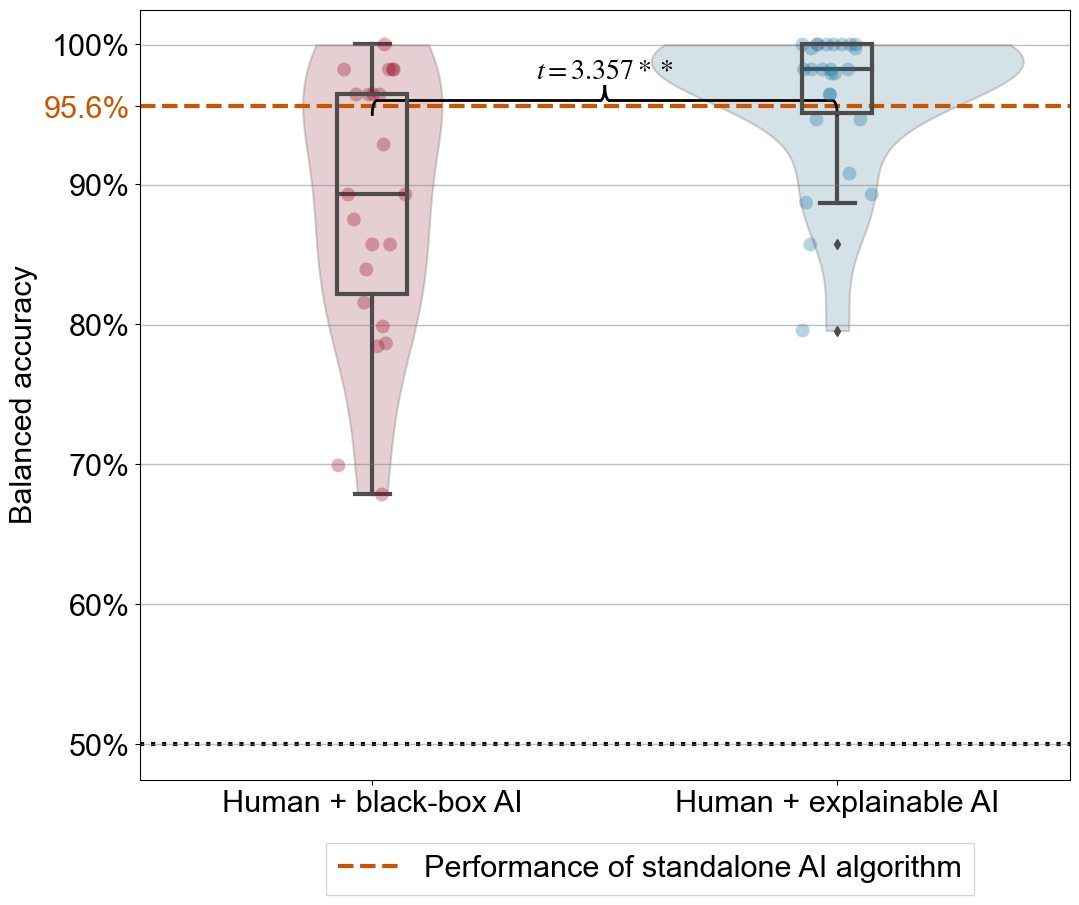

In [16]:
# Plot balanced accuracy for all participants
# Calculate t-statistic and p-value
t_stat = stats.ttest_ind(data["balanced_accuracy"][data["treatment"]=="a"], data["balanced_accuracy"][data["treatment"]=="b"], equal_var = False)[0]
p_val = stats.ttest_ind(data["balanced_accuracy"][data["treatment"]=="a"], data["balanced_accuracy"][data["treatment"]=="b"], equal_var = False)[1]/2
if p_val < 0.001:
    ast = '***'
elif p_val < 0.01:
    ast = '**'
elif p_val < 0.05:
    ast = '*'
else:
    ast = ' '
print("t-stat: " + str(round(t_stat,3))+ ", P-val: " + str(round(p_val,4)))
fig = plt.figure()
ax = sns.violinplot(x="treatment", y="balanced_accuracy", data=data, inner=None, palette=[red, blue], alpha=0.4, cut=0, order=["a", "b"])
for art in ax.collections:
    art.set_alpha(0.2)
ax1 = sns.boxplot(x="treatment", y="balanced_accuracy", data=data, orient="v", width=0.15, color="grey", linewidth=3, boxprops={'facecolor':'none', "zorder":10}, order=["a", "b"])
ax1 = sns.stripplot(x="treatment", y="balanced_accuracy", data=data, palette=[red, blue], size=10, jitter=0.075, order=["a", "b"], alpha=0.3)
#plt.scatter(0, data[data['treatment'] == 'a']['balanced_accuracy'].mean(), marker='s', color='black', s=50, alpha=0.6)
#plt.scatter(1, data[data['treatment'] == 'b']['balanced_accuracy'].mean(), marker='s', color='black', s=50, alpha=0.6, label='Mean')
plt.hlines(ai_bacc, -0.5, 1.5, linestyles='--', color=orange, linewidth=3, alpha=1, label='Performance of standalone AI algorithm')
plt.hlines(0.5, -0.5, 1.5, linestyles='dotted', color='black', linewidth=3, alpha=1)
for i in np.arange(0.5, 1.09, 0.1):
    plt.hlines(i, -0.5, 1.5, color='grey', linewidth=1, alpha=0.5)
plt.xticks([0, 1], ["Human + black-box AI", "Human + explainable AI"])
plt.yticks([0.5, 0.6, 0.7, 0.8, 0.9, 1, ai_bacc], labels=['50%', '60%', '70%', '80%', '90%', '100%', f'{np.round(ai_bacc*100, 1)}%'])
plt.xlabel("")
plt.xlim(-0.5, 1.5)
plt.ylabel("Balanced accuracy")
plt.legend(loc=(0.2, -0.15), fancybox=False)
ax.get_yticklabels()[-1].set_color((0.8,0.33,0))
curlyBrace(fig, ax, [0, 0.95], [1, 0.95], 0.01, bool_auto=False, str_text=f'$t={np.round(np.abs(t_stat),3)}{ast}$', color='black', lw=2, int_line_num=1, fontdict=font)
plt.savefig('../results/results_balanced_accuracy_study2.pdf', bbox_inches='tight')

t-stat: -3.357, P-val: 0.001
t-stat: -2.876, P-val: 0.0035


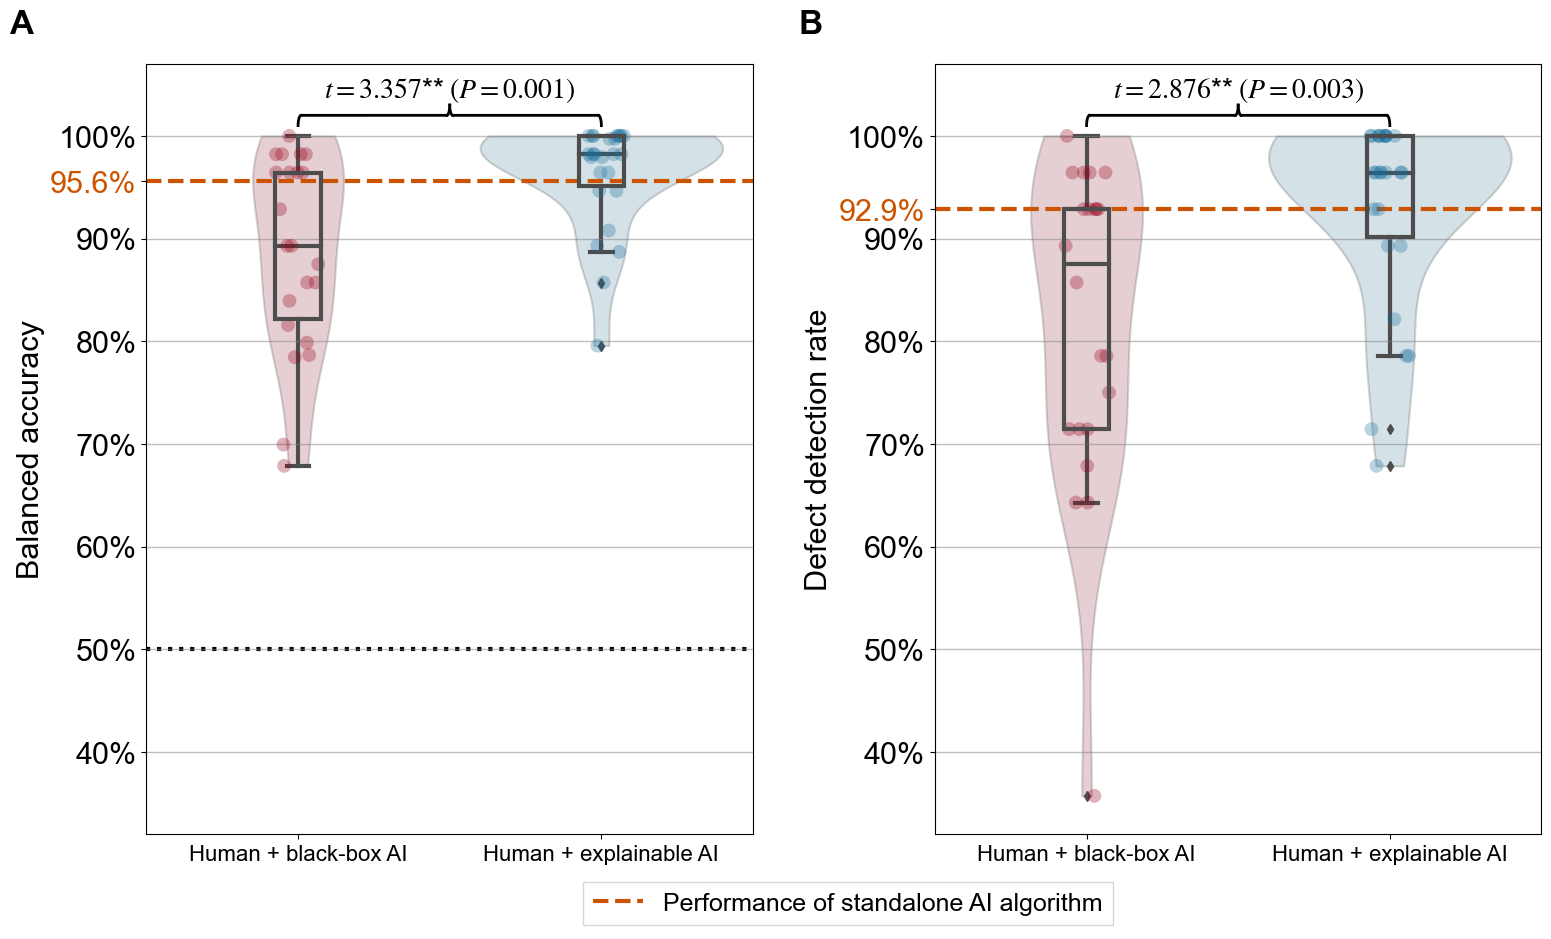

In [19]:
# Plot balanced accuracy and disease detection rate for all participants
# Calculate t-statistic and p-value
plt.figure(figsize=(18, 10))
plt.subplots_adjust(wspace=0.3)
for metric in ['balanced_accuracy', 'defect_detection_rate']:
    if metric == 'balanced_accuracy':
        ai_metric = ai_bacc
        plot_id = 1
        label = 'Balanced accuracy'
        legend = 'Performance of standalone AI algorithm'
    elif metric == 'defect_detection_rate':
        ai_metric = ai_ddr
        plot_id = 2
        label = 'Defect detection rate'
        legend = None
    else:
        raise ValueError('Unknown metric', metric)
    plt.subplot(1, 2, plot_id)
    t_stat = stats.ttest_ind(data[metric][data["treatment"]=="a"], data[metric][data["treatment"]=="b"], equal_var = False)[0]
    p_val = stats.ttest_ind(data[metric][data["treatment"]=="a"], data[metric][data["treatment"]=="b"], equal_var = False)[1]/2
    if p_val < 0.001:
        ast = '***'
    elif p_val < 0.01:
        ast = '**'
    elif p_val < 0.05:
        ast = '*'
    else:
        ast = ' '
    print("t-stat: " + str(round(t_stat,3))+ ", P-val: " + str(round(p_val,4)))
    #fig = plt.figure()
    ax = sns.violinplot(x="treatment", y=metric, data=data, inner=None, palette=[red, blue], alpha=0.4, cut=0, order=["a", "b"])
    for art in ax.collections:
        art.set_alpha(0.2)
    ax1 = sns.boxplot(x="treatment", y=metric, data=data, orient="v", width=0.15, color="grey", linewidth=3, boxprops={'facecolor':'none', "zorder":10}, order=["a", "b"])
    ax1 = sns.stripplot(x="treatment", y=metric, data=data, palette=[red, blue], size=10, jitter=0.075, order=["a", "b"], alpha=0.3)
    #plt.scatter(0, data[data['treatment'] == 'a']['balanced_accuracy'].mean(), marker='s', color='black', s=50, alpha=0.6)
    #plt.scatter(1, data[data['treatment'] == 'b']['balanced_accuracy'].mean(), marker='s', color='black', s=50, alpha=0.6, label='Mean')
    plt.hlines(ai_metric, -0.5, 1.5, linestyles='--', color=orange, linewidth=3, alpha=1, label=legend)
    if metric == 'balanced_accuracy':
        plt.hlines(0.5, -0.5, 1.5, linestyles='dotted', color='black', linewidth=3, alpha=1)
    for i in np.arange(0.4, 1.09, 0.1):
        plt.hlines(i, -0.5, 1.5, color='grey', linewidth=1, alpha=0.5)
    plt.xticks([0, 1], ["Human + black-box AI", "Human + explainable AI"], fontsize=16)
    plt.yticks([0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, ai_metric], labels=['40%', '50%', '60%', '70%', '80%', '90%', '100%', f'{np.round(ai_metric*100, 1)}%'])
    plt.xlabel(None)
    plt.ylabel(label)
    plt.xlim(-0.5, 1.5)
    plt.ylim(0.32, 1.07)
    #plt.title(label)
    ax.get_yticklabels()[-1].set_color((0.8,0.33,0))
    brace_y_offset = data[metric].max() + 0.01
    curlyBrace(fig, ax, [0, 1.01], [1, 1.01], 0.01, bool_auto=False, str_text=f'$t={np.round(np.abs(t_stat),3)}$'+ f'{ast}'+ f'$\, \, (P={np.round(p_val, 3)})$', color='black', lw=2, int_line_num=1, fontdict=font)
    #if plot_id == 1:
    #    plt.legend(loc=(0.4, -0.15))
    if metric == 'balanced_accuracy':
        plt.text(-0.95, 1.1, 'A', weight='bold', fontsize=24)
    else:
        plt.text(-0.95, 1.1, 'B', weight='bold', fontsize=24)
plt.figlegend(loc=(0.376, 0.015), fancybox=False, fontsize=18)
#plt.tight_layout()
plt.savefig('../results/results_combined_study2.pdf', bbox_inches='tight')

### Statistical test for balanced accuracy

In [18]:
# Print mean balanced accuracy for treatment arms
print(round(data["balanced_accuracy"][data["treatment"]=="a"].mean()*100,1))
print(round(data["balanced_accuracy"][data["treatment"]=="b"].mean()*100,1))

88.6
96.3


In [19]:
# Calculate difference in means
np.round(data["balanced_accuracy"][data["treatment"]=="b"].mean()*100 - data["balanced_accuracy"][data["treatment"]=="a"].mean()*100, 1)

7.7

In [20]:
# Print median balanced accuracy for treatment arms
print(round(data["balanced_accuracy"][data["treatment"]=="a"].median()*100,1))
print(round(data["balanced_accuracy"][data["treatment"]=="b"].median()*100,1))

89.3
98.2


In [21]:
# One-sided Welch's t-test for balanced accuracy ("human + black-box AI" vs. "human + explainable AI")
t_stat = stats.ttest_ind(data["balanced_accuracy"][data["treatment"]=="a"], data["balanced_accuracy"][data["treatment"]=="b"], equal_var = False)[0]
p_val = stats.ttest_ind(data["balanced_accuracy"][data["treatment"]=="a"], data["balanced_accuracy"][data["treatment"]=="b"], equal_var = False)[1]/2
print("t-stat: " + str(round(t_stat,3))+ ", P-val: " + str(round(p_val,4)))

t-stat: -3.357, P-val: 0.001


### OLS Regression for balanced accuracy

In [22]:
# OLS regression model without control variables
X = data.loc[:,["treatment"]]
X = X[X["treatment"] != "c"]
X["treatment"] = np.where(X["treatment"] == "a", 0, 1)
X = sm.add_constant(X)
X = X.astype(float)
y = data.loc[:, "balanced_accuracy"].astype(float)*100
y = y.loc[X.index]
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:      balanced_accuracy   R-squared:                       0.212
Model:                            OLS   Adj. R-squared:                  0.194
Method:                 Least Squares   F-statistic:                     12.34
Date:                Tue, 16 Apr 2024   Prob (F-statistic):            0.00101
Time:                        16:36:53   Log-Likelihood:                -163.93
No. Observations:                  48   AIC:                             331.9
Df Residuals:                      46   BIC:                             335.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         88.5986      1.603     55.260      0.0

### OLS Regression for defect detection rate

In [14]:
# OLS regression model without control variables
X = data.loc[:,["treatment"]]
X = X[X["treatment"] != "c"]
X["treatment"] = np.where(X["treatment"] == "a", 0, 1)
X = sm.add_constant(X)
X = X.astype(float)
y = data.loc[:, "defect_detection_rate"].astype(float)*100
y = y.loc[X.index]
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                              OLS Regression Results                             
Dep. Variable:     defect_detection_rate   R-squared:                       0.163
Model:                               OLS   Adj. R-squared:                  0.145
Method:                    Least Squares   F-statistic:                     8.959
Date:                   Mon, 11 Nov 2024   Prob (F-statistic):            0.00443
Time:                           10:16:34   Log-Likelihood:                -189.09
No. Observations:                     48   AIC:                             382.2
Df Residuals:                         46   BIC:                             385.9
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         81.9805 

### Analysis of adherence to accurate predictions

In [23]:
# Print mean values for how often participants follow accurate predictions ("human + black-box AI" vs. "human + explainable AI")
print(round(data["adherence_accurate_prediction"][data["treatment"]=="a"].mean()*100,1))
print(round(data["adherence_accurate_prediction"][data["treatment"]=="b"].mean()*100,1))

93.5
98.6


In [24]:
# One-sided Welch's t-test for how often participants follow accurate predictions ("human + black-box AI" vs. "human + explainable AI")
t_stat = stats.ttest_ind(data["adherence_accurate_prediction"][data["treatment"]=="a"], data["adherence_accurate_prediction"][data["treatment"]=="b"], equal_var = False)[0]
p_val = stats.ttest_ind(data["adherence_accurate_prediction"][data["treatment"]=="a"], data["adherence_accurate_prediction"][data["treatment"]=="b"], equal_var = False)[1]/2
print("t-stat: " + str(round(t_stat,3))+ ", P-val: " + str(round(p_val,4)))

t-stat: -2.437, P-val: 0.0114


### Analysis of overruling of wrong predictions

In [25]:
# Print mean values for how often participants overrule wrong predictions ("human + black-box AI" vs. "human + explainable AI")
print(round(data["overrule_wrong_prediction"][data["treatment"]=="a"].mean()*100,1))
print(round(data["overrule_wrong_prediction"][data["treatment"]=="b"].mean()*100,1))

86.4
96.9


In [26]:
# One-sided Welch's t-test for how often participants overrule wrong predictions ("human + explainable AI" vs. "human without AI")
t_stat = stats.ttest_ind(data["overrule_wrong_prediction"][data["treatment"]=="a"], data["overrule_wrong_prediction"][data["treatment"]=="b"], equal_var = False)[0]
p_val = stats.ttest_ind(data["overrule_wrong_prediction"][data["treatment"]=="a"], data["overrule_wrong_prediction"][data["treatment"]=="b"], equal_var = False)[1]/2
print("t-stat: " + str(round(t_stat, 3))+ ", P-val: " + str(round(p_val, 4)))

t-stat: -2.631, P-val: 0.0065


### Analysis of decision speed

In [27]:
# Print mean values for participants' median decision speed ("human + black-box AI" vs. "human + explainable AI")
print(round(data["median_decision_speed"][data["treatment"]=="a"].mean(),2))
print(round(data["median_decision_speed"][data["treatment"]=="b"].mean(),2))

5.01
4.88


In [28]:
# One-sided Welch's t-test for participants' median decision speed  ("human + black-box AI" vs. "human + explainable AI")
t_stat = stats.ttest_ind(data["median_decision_speed"][data["treatment"]=="a"], data["median_decision_speed"][data["treatment"]=="b"], equal_var = False)[0]
p_val = stats.ttest_ind(data["median_decision_speed"][data["treatment"]=="a"], data["median_decision_speed"][data["treatment"]=="b"], equal_var = False)[1]/2
print("t-stat: " + str(round(t_stat,3))+ ", P-val: " + str(round(p_val,4)))

t-stat: 0.308, P-val: 0.3797


## Supplement C: Preregistered hypotheses

### Hypothesis H1: Explainable AI improves the overall task performance (measured by the balanced accuracy and defect detection rate) compared to humans without AI (i.e., manual inspection).

not part of preregistration

### Hypothesis H2: Explainable AI improves the overall task performance (measured by the balanced accuracy and defect detection rate) compared to black-box AI.

In [29]:
# One-sided Welch's t-test for balanced accuracy ("human + black-box AI" vs. "human + explainable AI")
t_stat = stats.ttest_ind(data["balanced_accuracy"][data["treatment"]=="a"], data["balanced_accuracy"][data["treatment"]=="b"], equal_var = False)[0]
p_val = stats.ttest_ind(data["balanced_accuracy"][data["treatment"]=="a"], data["balanced_accuracy"][data["treatment"]=="b"], equal_var = False)[1]/2
print("t-stat: " + str(round(t_stat,3))+ ", P-val: " + str(round(p_val,4)))

t-stat: -3.357, P-val: 0.001


In [30]:
# One-sided Welch's t-test for defect detection rate ("human + black-box AI" vs. "human + explainable AI")
t_stat = stats.ttest_ind(data["defect_detection_rate"][data["treatment"]=="a"], data["defect_detection_rate"][data["treatment"]=="b"], equal_var = False)[0]
p_val = stats.ttest_ind(data["defect_detection_rate"][data["treatment"]=="a"], data["defect_detection_rate"][data["treatment"]=="b"], equal_var = False)[1]/2
print("t-stat: " + str(round(t_stat,3))+ ", P-val: " + str(round(p_val,4)))

t-stat: -2.876, P-val: 0.0035


### Hypothesis H3: Explainable AI reduces variation in task performance (measured by the variance in the balanced accuracy and defect detection rate) compared to black-box AI.

In [31]:
# Levene's test for balanced accuracy ("human + black-box AI" vs. "human + explainable AI")
W_stat = stats.levene(data["balanced_accuracy"][data["treatment"]=="a"], data["balanced_accuracy"][data["treatment"]=="b"])[0]
p_val = stats.levene(data["balanced_accuracy"][data["treatment"]=="a"], data["balanced_accuracy"][data["treatment"]=="b"])[1]
print("W-stat: " + str(round(W_stat,3))+ ", P-val: " + str(round(p_val,4)))

W-stat: 10.438, P-val: 0.0023


In [32]:
# Levene's test for defect detection rate ("human + black-box AI" vs. "human + explainable AI")
W_stat = stats.levene(data["defect_detection_rate"][data["treatment"]=="a"], data["defect_detection_rate"][data["treatment"]=="b"])[0]
p_val = stats.levene(data["defect_detection_rate"][data["treatment"]=="a"], data["defect_detection_rate"][data["treatment"]=="b"])[1]
print("W-stat: " + str(round(W_stat,3))+ ", P-val: " + str(round(p_val,4)))

W-stat: 5.515, P-val: 0.0232


### Hypothesis H4: Explainable AI increases the trust in model decisions (measured by the rate of correct model decisions that are not overruled by the user) compared to black-box AI.

In [33]:
# Print mean values for how often participants follow accurate predictions ("human + black-box AI" vs. "human + explainable AI")
t_stat = stats.ttest_ind(data["adherence_accurate_prediction"][data["treatment"]=="a"], data["adherence_accurate_prediction"][data["treatment"]=="b"], equal_var = False)[0]
p_val = stats.ttest_ind(data["adherence_accurate_prediction"][data["treatment"]=="a"], data["adherence_accurate_prediction"][data["treatment"]=="b"], equal_var = False)[1]/2
print("t-stat: " + str(round(t_stat,3))+ ", P-val: " + str(round(p_val,4)))

t-stat: -2.437, P-val: 0.0114


## Supplement D: Results with defect detection rate and precision

t-stat: -2.876, P-val: 0.0035
t-stat: -1.674, P-val: 0.0533


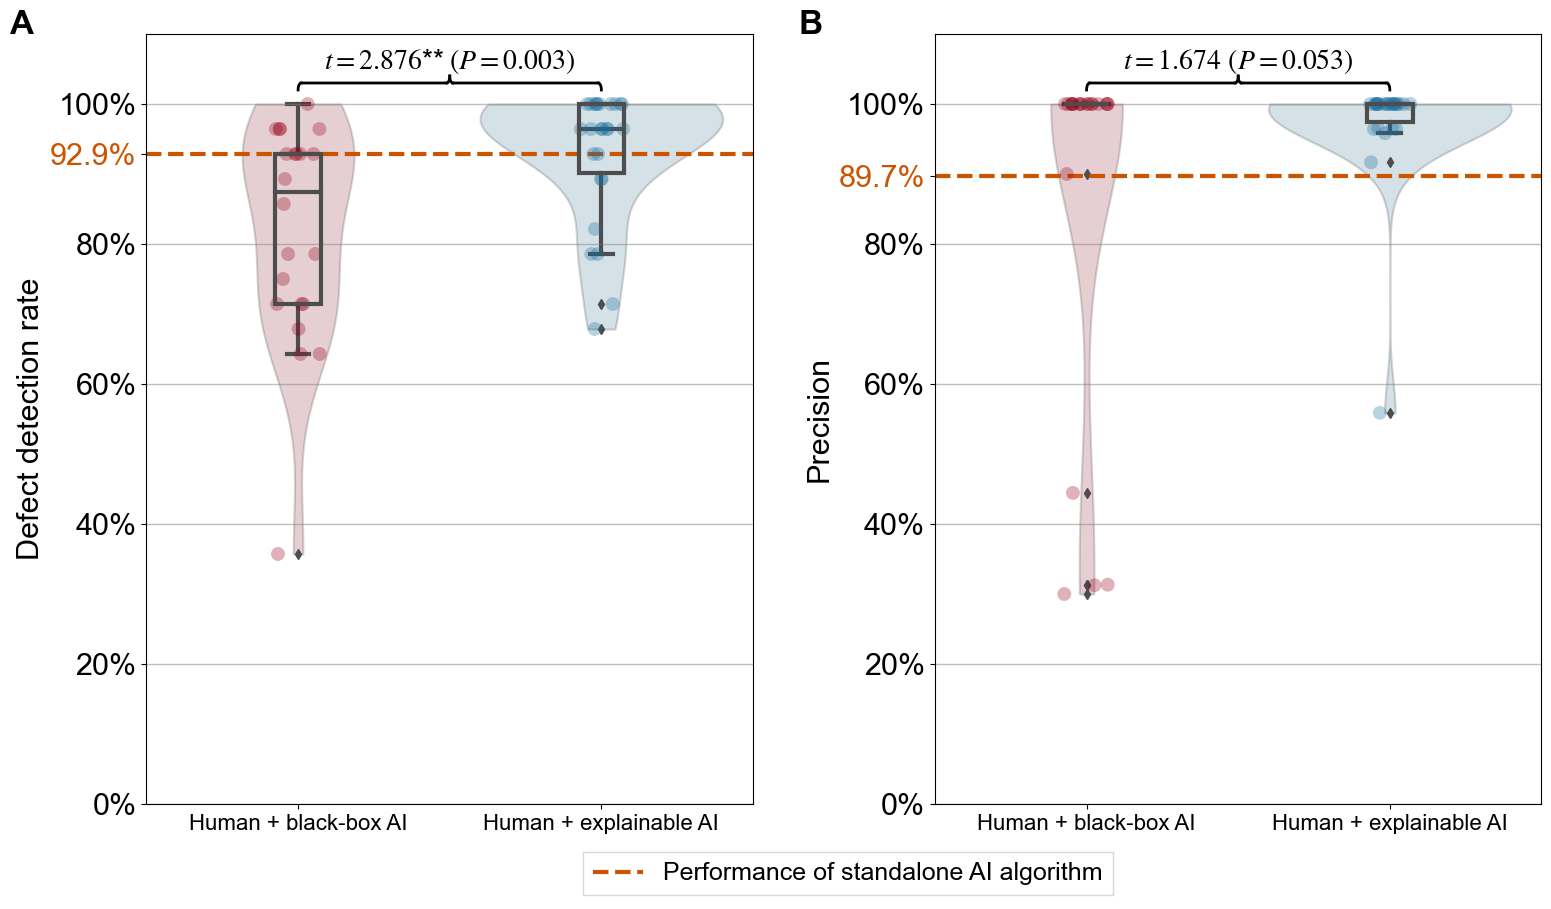

In [20]:
# Plot disease detection rate and precision for all participants
# Calculate t-statistic and p-value
plt.figure(figsize=(18, 10))
plt.subplots_adjust(wspace=0.3)
for metric in ['defect_detection_rate', 'precision']:
    if metric == 'defect_detection_rate':
        ai_metric = ai_ddr
        plot_id = 1
        label = 'Defect detection rate'
        legend = 'Performance of standalone AI algorithm'
    elif metric == 'precision':
        ai_metric = ai_prec
        plot_id = 2
        label = 'Precision'
        legend = None
    else:
        raise ValueError('Unknown metric', metric)
    plt.subplot(1, 2, plot_id)
    t_stat = stats.ttest_ind(data[metric][data["treatment"]=="a"], data[metric][data["treatment"]=="b"], equal_var = False)[0]
    p_val = stats.ttest_ind(data[metric][data["treatment"]=="a"], data[metric][data["treatment"]=="b"], equal_var = False)[1]/2
    if p_val < 0.001:
        ast = '***'
    elif p_val < 0.01:
        ast = '**'
    elif p_val < 0.05:
        ast = '*'
    else:
        ast = ' '
    print("t-stat: " + str(round(t_stat,3))+ ", P-val: " + str(round(p_val,4)))
    #fig = plt.figure()
    ax = sns.violinplot(x="treatment", y=metric, data=data, inner=None, palette=[red, blue], alpha=0.4, cut=0, order=["a", "b"])
    for art in ax.collections:
        art.set_alpha(0.2)
    ax1 = sns.boxplot(x="treatment", y=metric, data=data, orient="v", width=0.15, color="grey", linewidth=3, boxprops={'facecolor':'none', "zorder":10}, order=["a", "b"])
    ax1 = sns.stripplot(x="treatment", y=metric, data=data, palette=[red, blue], size=10, jitter=0.075, order=["a", "b"], alpha=0.3)
    #plt.scatter(0, data[data['treatment'] == 'a']['balanced_accuracy'].mean(), marker='s', color='black', s=50, alpha=0.6)
    #plt.scatter(1, data[data['treatment'] == 'b']['balanced_accuracy'].mean(), marker='s', color='black', s=50, alpha=0.6, label='Mean')
    plt.hlines(ai_metric, -0.5, 1.5, linestyles='--', color=orange, linewidth=3, alpha=1, label=legend)
    if metric == 'balanced_accuracy':
        plt.hlines(0.5, -0.5, 1.5, linestyles='dotted', color='black', linewidth=3, alpha=1)
    for i in np.arange(0.0, 1.09, 0.2):
        plt.hlines(i, -0.5, 1.5, color='grey', linewidth=1, alpha=0.5)
    plt.xticks([0, 1], ["Human + black-box AI", "Human + explainable AI"], fontsize=16)
    plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1, ai_metric], labels=['0%', '20%', '40%', '60%', '80%', '100%', f'{np.round(ai_metric*100, 1)}%'])
    plt.xlabel(None)
    plt.ylabel(label)
    plt.xlim(-0.5, 1.5)
    plt.ylim(0, 1.1)
    #plt.title(label)
    ax.get_yticklabels()[-1].set_color((0.8,0.33,0))
    brace_y_offset = data[metric].max() + 0.01
    if ast == ' ':
        curlyBrace(fig, ax, [0, 1.02], [1, 1.02], 0.01, bool_auto=False, str_text=f'$t={np.round(np.abs(t_stat),3)}$'+ f'{ast}'+ f'$(P={np.round(p_val, 3)})$', color='black', lw=2, int_line_num=1, fontdict=font)
    else:
        curlyBrace(fig, ax, [0, 1.02], [1, 1.02], 0.01, bool_auto=False, str_text=f'$t={np.round(np.abs(t_stat),3)}$'+ f'{ast}'+ f'$\, \, (P={np.round(p_val, 3)})$', color='black', lw=2, int_line_num=1, fontdict=font)
    #if plot_id == 1:
    #    plt.legend(loc=(0.4, -0.15))
    if metric == 'defect_detection_rate':
        plt.text(-0.95, 1.1, 'A', weight='bold', fontsize=24)
    else:
        plt.text(-0.95, 1.1, 'B', weight='bold', fontsize=24)
plt.figlegend(loc=(0.376, 0.015), fancybox=False, fontsize=18)
#plt.tight_layout()
plt.savefig('../results/results_combined_study2_supp.pdf', bbox_inches='tight')

In [35]:
# Print median precision for treatment arms
print(round(data["precision"][data["treatment"]=="a"].median()*100,1))
print(round(data["precision"][data["treatment"]=="b"].median()*100,1))

100.0
100.0


In [36]:
# Print mean precision for treatment arms
print(round(data["precision"][data["treatment"]=="a"].mean()*100,1))
print(round(data["precision"][data["treatment"]=="b"].mean()*100,1))

87.6
97.3


In [37]:
# One-sided Welch's t-test for precision ("human + black-box AI" vs. "human + explainable AI")
t_stat = stats.ttest_ind(data["precision"][data["treatment"]=="a"], data["precision"][data["treatment"]=="b"], equal_var = False)[0]
p_val = stats.ttest_ind(data["precision"][data["treatment"]=="a"], data["precision"][data["treatment"]=="b"], equal_var = False)[1]/2
print("t-stat: " + str(round(t_stat,3))+ ", P-val: " + str(round(p_val,4)))

t-stat: -1.674, P-val: 0.0533


In [38]:
# OLS regression model without control variables
X = data.loc[:,["treatment"]]
X = X[X["treatment"] != "c"]
X["treatment"] = np.where(X["treatment"] == "a", 0, 1)
X = sm.add_constant(X)
X = X.astype(float)
y = data.loc[:, "precision"].astype(float)*100
y = y.loc[X.index]
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              precision   R-squared:                       0.065
Model:                            OLS   Adj. R-squared:                  0.045
Method:                 Least Squares   F-statistic:                     3.211
Date:                Tue, 16 Apr 2024   Prob (F-statistic):             0.0797
Time:                        16:36:54   Log-Likelihood:                -207.58
No. Observations:                  48   AIC:                             419.2
Df Residuals:                      46   BIC:                             422.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         87.5918      3.980     22.007      0.0

## Supplement H: Randomization checks

In [39]:
# Print frequencies for age, gender, education
print("age (counts in a): \n" + str(data["age"][data["treatment"]=="a"].value_counts().sort_index()))
print("age (counts in b): \n\n" + str(data["age"][data["treatment"]=="b"].value_counts().sort_index()))
print("gender (counts in a): \n" + str(data["gender"][data["treatment"]=="a"].value_counts().sort_index()))
print("gender (counts in b): \n" + str(data["gender"][data["treatment"]=="b"].value_counts().sort_index()))
print("education (counts in a): \n" + str(data["education"][data["treatment"]=="a"].value_counts().sort_index()))
print("education (counts in b): \n" + str(data["education"][data["treatment"]=="b"].value_counts().sort_index()))

age (counts in a): 
2.0    1
3.0    7
4.0    8
5.0    4
6.0    2
Name: age, dtype: int64
age (counts in b): 

2.0     1
3.0     3
4.0     9
5.0    12
6.0     1
Name: age, dtype: int64
gender (counts in a): 
0    16
1     6
Name: gender, dtype: int64
gender (counts in b): 
0    17
1     9
Name: gender, dtype: int64
education (counts in a): 
2    9
3    4
4    2
5    3
6    3
7    1
Name: education, dtype: int64
education (counts in b): 
2    14
3     2
4     3
5     3
6     3
7     1
Name: education, dtype: int64


In [40]:
# Print mean and standard deviation for tenure
print("tenure (mean in a): " + str(round(data["tenure"][data["treatment"]=="a"].mean(),2)))
print("tenure (std in a): " + str(round(data["tenure"][data["treatment"]=="a"].std(),2)))
print("tenure (mean in b): " + str(round(data["tenure"][data["treatment"]=="b"].mean(),2)))
print("tenure (std in b): " + str(round(data["tenure"][data["treatment"]=="b"].std(),2)))

tenure (mean in a): 11.91
tenure (std in a): 8.83
tenure (mean in b): 15.38
tenure (std in b): 10.42


In [41]:
# Print P-values for randomization checks
print("age (P-value): " + str(round(stats.chi2_contingency(pd.concat([data["age"][data["treatment"]=="a"].value_counts(), data["age"][data["treatment"]=="b"].value_counts()], axis=1).fillna(0).T)[1],3)))
print("gender (P-value): " + str(round(stats.chi2_contingency(pd.concat([data["gender"][data["treatment"]=="a"].value_counts(), data["gender"][data["treatment"]=="b"].value_counts()], axis=1).fillna(0).T)[1],3)))
print("education (P-value): " + str(round(stats.chi2_contingency(pd.concat([data["education"][data["treatment"]=="a"].value_counts(), data["education"][data["treatment"]=="b"].value_counts()], axis=1).fillna(0).T)[1],3)))
print("tenure (P-value): " + str(round(stats.ttest_ind(data["tenure"][data["treatment"]=="a"], data["tenure"][data["treatment"]=="b"], equal_var=False)[1],3)))

age (P-value): 0.223
gender (P-value): 0.815
education (P-value): 0.897
tenure (P-value): 0.217


## Supplement I: Regression models

In [42]:
# OLS regression model (1) for balanced accuracy
X = data.loc[:,["treatment", "age", "education", "gender", "tenure"]]
X["treatment"] = np.where(X["treatment"] == "a", 0, 1)
X = sm.add_constant(X)
X = X.astype(float)
y = data.loc[:, "balanced_accuracy"].astype(float)*100
y = y.loc[X.index]
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:      balanced_accuracy   R-squared:                       0.370
Model:                            OLS   Adj. R-squared:                  0.295
Method:                 Least Squares   F-statistic:                     4.942
Date:                Tue, 16 Apr 2024   Prob (F-statistic):            0.00120
Time:                        16:36:54   Log-Likelihood:                -158.53
No. Observations:                  48   AIC:                             329.1
Df Residuals:                      42   BIC:                             340.3
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         87.5330      5.879     14.890      0.0

In [43]:
results.pvalues['treatment']

0.0003457845929976218

In [44]:
# Quasi-binomial regression model (1) for balanced accuracy
model = sm.GLM(y/100, X, family=sm.families.Binomial())
results = model.fit(scale="X2")
print(results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:      balanced_accuracy   No. Observations:                   48
Model:                            GLM   Df Residuals:                       42
Model Family:                Binomial   Df Model:                            5
Link Function:                  Logit   Scale:                        0.073425
Method:                          IRLS   Log-Likelihood:                -8.6884
Date:                Tue, 16 Apr 2024   Deviance:                       2.7907
Time:                        16:36:54   Pearson chi2:                     3.08
No. Iterations:                     8   Pseudo R-squ. (CS):            0.03889
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.5111      0.912      1.657      0.0

In [45]:
results.pvalues['treatment']

0.0001407412468429712

In [46]:
# OLS regression model (1) for defect detection rate
X = data.loc[:,["treatment", "age", "education", "gender", "tenure"]]
X["treatment"] = np.where(X["treatment"] == "a", 0, 1)
X = sm.add_constant(X)
X = X.astype(float)
y = data.loc[:, "defect_detection_rate"].astype(float)*100
y = y.loc[X.index]
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                              OLS Regression Results                             
Dep. Variable:     defect_detection_rate   R-squared:                       0.251
Model:                               OLS   Adj. R-squared:                  0.162
Method:                    Least Squares   F-statistic:                     2.817
Date:                   Tue, 16 Apr 2024   Prob (F-statistic):             0.0278
Time:                           16:36:54   Log-Likelihood:                -186.42
No. Observations:                     48   AIC:                             384.8
Df Residuals:                         42   BIC:                             396.1
Df Model:                              5                                         
Covariance Type:               nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         76.6305 

In [47]:
results.pvalues['treatment']

0.002946020831568147

In [48]:
# Quasi-binomial regression model (1) for defect detection rate
model = sm.GLM(y/100, X, family=sm.families.Binomial())
results = model.fit(scale="X2")
print(results.summary())

                   Generalized Linear Model Regression Results                   
Dep. Variable:     defect_detection_rate   No. Observations:                   48
Model:                               GLM   Df Residuals:                       42
Model Family:                   Binomial   Df Model:                            5
Link Function:                     Logit   Scale:                         0.14454
Method:                             IRLS   Log-Likelihood:                -12.459
Date:                   Tue, 16 Apr 2024   Deviance:                       5.8521
Time:                           16:36:54   Pearson chi2:                     6.07
No. Iterations:                        8   Pseudo R-squ. (CS):            0.04463
Covariance Type:               nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7835 

In [49]:
results.pvalues['treatment']

0.0017068896352189355

In [50]:
# OLS regression model (2) for balanced accuracy
X = data.loc[:,["treatment", "age", "education", "gender", "tenure", "it_skills"]]
X["treatment"] = np.where(X["treatment"] == "a", 0, 1)
X = sm.add_constant(X)
X = X.astype(float)
y = data.loc[:, "balanced_accuracy"].astype(float)*100
y = y.loc[X.index]
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:      balanced_accuracy   R-squared:                       0.403
Model:                            OLS   Adj. R-squared:                  0.316
Method:                 Least Squares   F-statistic:                     4.616
Date:                Tue, 16 Apr 2024   Prob (F-statistic):            0.00115
Time:                        16:36:54   Log-Likelihood:                -157.25
No. Observations:                  48   AIC:                             328.5
Df Residuals:                      41   BIC:                             341.6
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         82.3475      6.747     12.204      0.0

In [51]:
results.pvalues['treatment']

0.0008974898155309641

In [52]:
# Quasi-binomial regression model (2) for balanced accuracy
model = sm.GLM(y/100, X, family=sm.families.Binomial())
results = model.fit(scale="X2")
print(results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:      balanced_accuracy   No. Observations:                   48
Model:                            GLM   Df Residuals:                       41
Model Family:                Binomial   Df Model:                            6
Link Function:                  Logit   Scale:                        0.078040
Method:                          IRLS   Log-Likelihood:                -8.6086
Date:                Tue, 16 Apr 2024   Deviance:                       2.6311
Time:                        16:36:54   Pearson chi2:                     3.20
No. Iterations:                     8   Pseudo R-squ. (CS):            0.04208
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6982      1.087      0.642      0.5

In [53]:
results.pvalues['treatment']

0.0010274140640594263

In [54]:
# OLS regression model (2) for defect detection rate
X = data.loc[:,["treatment", "age", "education", "gender", "tenure", "it_skills"]]
X["treatment"] = np.where(X["treatment"] == "a", 0, 1)
X = sm.add_constant(X)
X = X.astype(float)
y = data.loc[:, "defect_detection_rate"].astype(float)*100
y = y.loc[X.index]
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                              OLS Regression Results                             
Dep. Variable:     defect_detection_rate   R-squared:                       0.275
Model:                               OLS   Adj. R-squared:                  0.169
Method:                    Least Squares   F-statistic:                     2.595
Date:                   Tue, 16 Apr 2024   Prob (F-statistic):             0.0318
Time:                           16:36:54   Log-Likelihood:                -185.64
No. Observations:                     48   AIC:                             385.3
Df Residuals:                         41   BIC:                             398.4
Df Model:                              6                                         
Covariance Type:               nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         69.3306 

In [55]:
results.pvalues['treatment']

0.006298551813077665

In [56]:
# Quasi-binomial regression model (2) for defect detection rate
model = sm.GLM(y/100, X, family=sm.families.Binomial())
results = model.fit(scale="X2")
print(results.summary())

                   Generalized Linear Model Regression Results                   
Dep. Variable:     defect_detection_rate   No. Observations:                   48
Model:                               GLM   Df Residuals:                       41
Model Family:                   Binomial   Df Model:                            6
Link Function:                     Logit   Scale:                         0.15179
Method:                             IRLS   Log-Likelihood:                -12.371
Date:                   Tue, 16 Apr 2024   Deviance:                       5.6766
Time:                           16:36:54   Pearson chi2:                     6.22
No. Iterations:                        8   Pseudo R-squ. (CS):            0.04812
Covariance Type:               nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0887 

In [57]:
results.pvalues['treatment']

0.006049439593071739

In [58]:
# OLS regression model (3) for balanced accuracy
X = data.loc[:,["treatment", "age", "education", "gender", "tenure", "it_skills", "median_decision_speed"]]
X["treatment"] = np.where(X["treatment"] == "a", 0, 1)
X = sm.add_constant(X)
X = X.astype(float)
y = data.loc[:, "balanced_accuracy"].astype(float)*100
y = y.loc[X.index]
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:      balanced_accuracy   R-squared:                       0.407
Model:                            OLS   Adj. R-squared:                  0.303
Method:                 Least Squares   F-statistic:                     3.921
Date:                Tue, 16 Apr 2024   Prob (F-statistic):            0.00242
Time:                        16:36:54   Log-Likelihood:                -157.10
No. Observations:                  48   AIC:                             330.2
Df Residuals:                      40   BIC:                             345.2
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    80.44

In [59]:
results.pvalues['treatment']

0.0010126550559295495

In [60]:
# Quasi-binomial regression model (3) for balanced accuracy
model = sm.GLM(y/100, X, family=sm.families.Binomial())
results = model.fit(scale="X2")
print(results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:      balanced_accuracy   No. Observations:                   48
Model:                            GLM   Df Residuals:                       40
Model Family:                Binomial   Df Model:                            7
Link Function:                  Logit   Scale:                        0.077438
Method:                          IRLS   Log-Likelihood:                -8.5856
Date:                Tue, 16 Apr 2024   Deviance:                       2.5852
Time:                        16:36:54   Pearson chi2:                     3.10
No. Iterations:                     8   Pseudo R-squ. (CS):            0.04300
Covariance Type:            nonrobust                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.16

In [61]:
results.pvalues['treatment']

0.0009250580802498776

In [62]:
# OLS regression model (3) for defect detection rate
X = data.loc[:,["treatment", "age", "education", "gender", "tenure", "it_skills", "median_decision_speed"]]
X["treatment"] = np.where(X["treatment"] == "a", 0, 1)
X = sm.add_constant(X)
X = X.astype(float)
y = data.loc[:, "defect_detection_rate"].astype(float)*100
y = y.loc[X.index]
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                              OLS Regression Results                             
Dep. Variable:     defect_detection_rate   R-squared:                       0.320
Model:                               OLS   Adj. R-squared:                  0.201
Method:                    Least Squares   F-statistic:                     2.689
Date:                   Tue, 16 Apr 2024   Prob (F-statistic):             0.0222
Time:                           16:36:54   Log-Likelihood:                -184.11
No. Observations:                     48   AIC:                             384.2
Df Residuals:                         40   BIC:                             399.2
Df Model:                              7                                         
Covariance Type:               nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------


In [63]:
results.pvalues['treatment']

0.005583170488844244

In [64]:
# Quasi-binomial regression model (3) for defect detection rate
model = sm.GLM(y/100, X, family=sm.families.Binomial())
results = model.fit(scale="X2")
print(results.summary())

                   Generalized Linear Model Regression Results                   
Dep. Variable:     defect_detection_rate   No. Observations:                   48
Model:                               GLM   Df Residuals:                       40
Model Family:                   Binomial   Df Model:                            7
Link Function:                     Logit   Scale:                         0.13927
Method:                             IRLS   Log-Likelihood:                -12.129
Date:                   Tue, 16 Apr 2024   Deviance:                       5.1921
Time:                           16:36:54   Pearson chi2:                     5.57
No. Iterations:                        8   Pseudo R-squ. (CS):            0.05768
Covariance Type:               nonrobust                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------


In [65]:
results.pvalues['treatment']

0.003717730238497247

## Supplement J: Analysis with excluded participants

#### Get numbers of excluded participants per treatment arm

In [22]:
# Import study data (excluding dropouts)
data = pd.read_csv("data_study_02.csv")

In [23]:
# Rename treatment arms to "a" and "b"
data["treatment"][data["treatment"]=="human_with_black-box_AI"] = "a"
data["treatment"][data["treatment"]=="human_with_explainable_AI"] = "b"

In [24]:
data[data["completed_images"] != 200]["treatment"].value_counts()

a    5
b    1
Name: treatment, dtype: int64

In [25]:
data = data[data["completed_images"] == 200].copy()

In [26]:
data[data["defect_detection_rate"] == 0]["treatment"].value_counts()

a    1
Name: treatment, dtype: int64

In [27]:
data = data[data["defect_detection_rate"] != 0].copy()

In [28]:
data["treatment"].value_counts()

b    27
a    22
Name: treatment, dtype: int64

In [29]:
# Remove participants whose performance was more than three standard deviations worse than the mean of their respective treatment arm
cutoff_a = data["balanced_accuracy"][data["treatment"] == "a"].mean() - 3 * data["balanced_accuracy"][
    data["treatment"] == "a"].std()
cutoff_b = data["balanced_accuracy"][data["treatment"] == "b"].mean() - 3 * data["balanced_accuracy"][
    data["treatment"] == "b"].std()
data = data[~((data["treatment"] == "a") & (data["balanced_accuracy"] < cutoff_a))]
data = data[~((data["treatment"] == "b") & (data["balanced_accuracy"] < cutoff_b))]

In [30]:
data["treatment"].value_counts()

b    26
a    22
Name: treatment, dtype: int64

#### Perform OLS with all combinations of exclusion criteria

In [31]:
from itertools import combinations

In [32]:
# Import study data (excluding dropouts)
data = pd.read_csv("data_study_02.csv")

In [33]:
# Rename treatment arms to "a" and "b"
data["treatment"][data["treatment"]=="human_with_black-box_AI"] = "a"
data["treatment"][data["treatment"]=="human_with_explainable_AI"] = "b"

In [34]:
data["time-out"] = data["completed_images"] != 200

In [35]:
data["single_label"] = data["defect_detection_rate"] == 0

In [36]:
data["worse_3sds"] = ((data["treatment"] == "a") & (data["balanced_accuracy"] < cutoff_a)) | ((data["treatment"] == "b") & (data["balanced_accuracy"] < cutoff_b))

In [37]:
excl_criteria = ['time-out', 'single_label', 'worse_3sds']

In [38]:
list_combinations = list()

for n in range(len(excl_criteria)):
    list_combinations += list(combinations(excl_criteria, n))

In [48]:
results_df = pd.DataFrame(data=None, index=[str(i) for i in range(1, 8)])
results_df['time-out'] = ["\\xmark", "\\cmark", "\\xmark", "\\xmark", "\\cmark", "\\cmark", "\\xmark"]
results_df['single_label'] = ["\\xmark", "\\xmark", "\\cmark", "\\xmark", "\\cmark", "\\xmark", "\\cmark"]
results_df['worse_3sds'] = ["\\xmark", "\\xmark", "\\xmark", "\\cmark", "\\xmark", "\\cmark", "\\cmark"]
for metric in ["balanced_accuracy", "defect_detection_rate"]:
    results_df.loc[:, "Observations"] = np.nan
    results_df.loc[:, metric] = np.nan
for metric in ["balanced_accuracy", "defect_detection_rate"]:
    for sample_id, combination in enumerate(list_combinations):
        data_sub = data.copy()
        for criterion in combination:
            data_sub = data_sub[~data_sub[criterion]].copy()
        results_df.loc[str(int(sample_id+1)), "Observations"] = len(data_sub)
        #print("Model:", model_id+1)
        X = data_sub.loc[:, ["treatment"]]
        X["treatment"] = np.where(X["treatment"] == "a", 0, 1)
        X = sm.add_constant(X)
        X = X.astype(float)
        y = data_sub.loc[:, metric].astype(float)*100
        y = y.loc[X.index]
        model = sm.OLS(y, X)
        results = model.fit()
        #print("Coef:", np.round(results.params["treatment"], 3), "se:", np.round(results.bse["treatment"], 3), "p:", np.round(results.pvalues["treatment"], 5))
        if results.pvalues["treatment"] < 0.001:
            ast = "***"
        elif results.pvalues["treatment"] < 0.01:
            ast = "**"
        elif results.pvalues["treatment"] < 0.05:
            ast = "*"
        else:
            ast = ""
        results_df.loc[str(int(sample_id+1)), metric] = "{:.3f}".format(np.round(results.params["treatment"], 3))+ast + " " + "({:.3f})".format(np.round(results.bse["treatment"], 3))
results_df["Observations"] = results_df["Observations"].astype(int)

In [50]:
print(results_df.to_latex(escape=False, index=False))

\begin{tabular}{lllrll}
\toprule
time-out & single_label & worse_3sds &  Observations & balanced_accuracy & defect_detection_rate \\
\midrule
  \xmark &       \xmark &     \xmark &            56 &   8.143** (2.754) &       11.590* (4.965) \\
  \cmark &       \xmark &     \xmark &            50 &    7.944* (3.016) &       12.192* (5.472) \\
  \xmark &       \cmark &     \xmark &            55 &   6.769** (2.432) &        8.651* (4.077) \\
  \xmark &       \xmark &     \cmark &            54 &  8.120*** (2.042) &      10.961** (3.391) \\
  \cmark &       \cmark &     \xmark &            49 &    6.253* (2.642) &         8.628 (4.477) \\
  \cmark &       \xmark &     \cmark &            48 &   7.653** (2.178) &      11.014** (3.680) \\
  \xmark &       \cmark &     \cmark &            54 &  8.120*** (2.042) &      10.961** (3.391) \\
\bottomrule
\end{tabular}



#### Perform OLS with all combinations of exclusion criteria (old)

In [75]:
from itertools import combinations

In [76]:
# Import study data (excluding dropouts)
data = pd.read_csv("data_study_02.csv")

In [77]:
# Rename treatment arms to "a" and "b"
data["treatment"][data["treatment"]=="human_with_black-box_AI"] = "a"
data["treatment"][data["treatment"]=="human_with_explainable_AI"] = "b"

In [78]:
data["time-out"] = data["completed_images"] != 200

In [79]:
data["single_label"] = data["defect_detection_rate"] == 0

In [80]:
data["worse_3sds"] = ((data["treatment"] == "a") & (data["balanced_accuracy"] < cutoff_a)) | ((data["treatment"] == "b") & (data["balanced_accuracy"] < cutoff_b))

In [81]:
excl_criteria = ['time-out', 'single_label', 'worse_3sds']

In [82]:
list_combinations = list()

for n in range(len(excl_criteria)):
    list_combinations += list(combinations(excl_criteria, n))

In [83]:
covariates1 = ["treatment", "age", "education", "gender", "tenure"]
covariates2 = ["treatment", "age", "education", "gender", "tenure", "it_skills"]
covariates3 = ["treatment", "age", "education", "gender", "tenure", "it_skills", "median_decision_speed"]

In [84]:
results_df = pd.DataFrame(data=None, columns=[str(i) for i in range(1, 8)])
for metric in ["balanced_accuracy", "defect_detection_rate"]:
    for model_id, covariates in enumerate([covariates1, covariates2, covariates3]):
        results_df.loc["Observations", :] = np.nan
        results_df.loc[metric+"_"+str(int(model_id+1))+"_coef", :] = np.nan
        results_df.loc[metric+"_"+str(int(model_id+1))+"_se", :] = np.nan
for metric in ["balanced_accuracy", "defect_detection_rate"]:
    for sample_id, combination in enumerate(list_combinations):
        data_sub = data.copy()
        for criterion in combination:
            data_sub = data_sub[~data_sub[criterion]].copy()
        results_df.loc['Observations', str(int(sample_id+1))] = len(data_sub)
        for model_id, covariates in enumerate([covariates1, covariates2, covariates3]):
            #print("Model:", model_id+1)
            X = data_sub.loc[:, covariates]
            X["treatment"] = np.where(X["treatment"] == "a", 0, 1)
            X = sm.add_constant(X)
            X = X.astype(float)
            y = data_sub.loc[:, metric].astype(float)*100
            y = y.loc[X.index]
            model = sm.OLS(y, X)
            results = model.fit()
            #print("Coef:", np.round(results.params["treatment"], 3), "se:", np.round(results.bse["treatment"], 3), "p:", np.round(results.pvalues["treatment"], 5))
            if results.pvalues["treatment"] < 0.001:
                ast = "***"
            elif results.pvalues["treatment"] < 0.01:
                ast = "**"
            elif results.pvalues["treatment"] < 0.05:
                ast = "*"
            else:
                ast = ""
            results_df.loc[metric+"_"+str(int(model_id+1))+"_coef", str(int(sample_id+1))] = "{:.3f}".format(np.round(results.params["treatment"], 3))+ast
            results_df.loc[metric+"_"+str(int(model_id+1))+"_se", str(int(sample_id+1))] = "({:.3f})".format(np.round(results.bse["treatment"], 3))

In [85]:
# Formatter function to apply tiny font size
def tiny_font(x):
    return r'\tiny{' + str(x) + '}'

# Apply formatter to each column
formatters = {col: tiny_font for col in results_df.columns}

# Generate LaTeX code
latex_output = results_df.to_latex(formatters=formatters, escape=False, index=False)
print(latex_output)

\begin{tabular}{lllllll}
\toprule
              1 &              2 &              3 &                4 &              5 &               6 &                7 \\
\midrule
      \tiny{56} &      \tiny{50} &      \tiny{55} &        \tiny{54} &      \tiny{49} &       \tiny{48} &        \tiny{54} \\
 \tiny{7.987**} & \tiny{8.759**} & \tiny{6.559**} &  \tiny{7.935***} & \tiny{6.655**} & \tiny{8.131***} &  \tiny{7.935***} \\
 \tiny{(2.579)} & \tiny{(2.795)} & \tiny{(2.202)} &   \tiny{(1.912)} & \tiny{(2.465)} &  \tiny{(2.087)} &   \tiny{(1.912)} \\
 \tiny{7.830**} & \tiny{8.550**} & \tiny{6.068**} &  \tiny{7.513***} &  \tiny{5.874*} & \tiny{7.513***} &  \tiny{7.513***} \\
 \tiny{(2.602)} & \tiny{(2.834)} & \tiny{(2.158)} &   \tiny{(1.905)} & \tiny{(2.431)} &  \tiny{(2.098)} &   \tiny{(1.905)} \\
\tiny{9.200***} & \tiny{8.662**} & \tiny{6.878**} &  \tiny{8.101***} &  \tiny{6.001*} &  \tiny{7.508**} &  \tiny{8.101***} \\
 \tiny{(2.592)} & \tiny{(2.821)} & \tiny{(2.245)} &   \tiny{(1.979)} & \tin